# Unmap data from an image

Sometimes we'd like to rip **data** (i.e. the underlying digits) from a [pseudocolour (aka false colour) image](https://en.wikipedia.org/wiki/False_color). For example, maybe you found a nice map or seismic section in a paper, and want to try loading the data into some other software to play with.

The `gio.unmap_to_dataarray()` function attempts to do this. Keep your hopes in check though: depending on the circumstances, it might be impossible. 

**Note:** This function wraps `unmap()` from the [`unmap`](https://kwinkunks.github.io/unmap/) library. If you only want a NumPy array from the plot image, you could just use that function directly. All `gio` is doing is wrapping its output in an `xarray.DataArray`.

## Get images from the web

Let's write a little function to load images from the Internet and transform them into NumPy arrays.

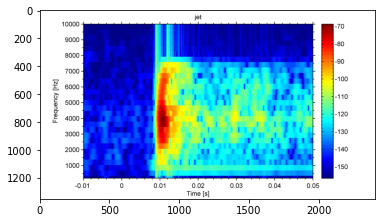

In [1]:
from io import BytesIO

import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def get_image_from_web(uri):
    data = requests.get(uri).content
    img = Image.open(BytesIO(data)).convert('RGB')
    rgb_im = np.asarray(img)[..., :3] / 255.
    return rgb_im

# An image from Matteo Niccoli's blog:
# https://mycartablog.com/2014/08/24/what-your-brain-does-with-colours-when-you-are-not-looking-part-1/
img = get_image_from_web('https://i0.wp.com/mycartablog.com/wp-content/uploads/2014/03/spectrogram_jet.png')

plt.imshow(img)

## An easy image

Let's start with that image, it looks approachable:

- It's large.
- It's a PNG, so losslessly compressed.
- No hillshading.
- It contains the colourmap, and Matteo tells us that it's `jet`

And, even better, when Matteo used it on his blog, he provided lots of other plots that we can compare to!

In [2]:
import gio

data = gio.unmap_to_dataarray(img, cmap='jet')

data

<xarray.DataArray (i: 1351, j: 2402)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * j        (j) float64 0.0 1.0 2.001 3.001 ... 2.4e+03 2.401e+03 2.402e+03
  * i        (i) float64 0.0 1.001 2.001 3.002 ... 1.349e+03 1.35e+03 1.351e+03
Attributes:
    source:   
    fname:

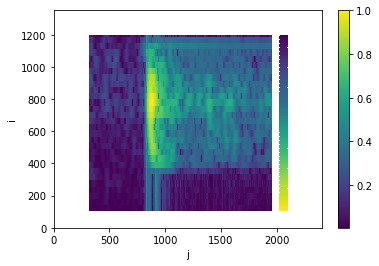

In [3]:
data.plot()

Notice that the data ranges from 0 to 1, whereas in the image the colorbar is labelled from about -160 to -70.

Also the `i` and `j` coordinates are just the indices from the NumPy array, whereas the original plot had time and frequency coordinates.

In the next section we'll fix these issues.

## Do more

Let's do more with this image!

We happen to know the colourmap was `jet` in this case, but we could give `gio` the pixel area of the colourmap, as a (left, top, right, bottom) tuple. We'll also pass in the `vrange` of the values, which we can estimate from the colourbar labels in the image. While we're at it, let's crop the result down to just the data area, and pass in the `extent` of the data in real-world coordinates (time and frequency in this case).

In [4]:
cmap = (2035, 102, 2079, 1198)       # (left, top, right, bottom)
crop = (312, 102, 1954, 1198)        # (left, top, right, bottom)
extent = (-0.01, 0.05, 200, 10_000)  # (left, right, bottom, top)
vrange = (-156.2, -69.0)
data = gio.unmap_to_dataarray(img, cmap=cmap, crop=crop, extent=extent, vrange=vrange)

data

<xarray.DataArray (x: 1096, y: 1642)>
array([[ -69.        ,  -69.        ,  -69.        , ...,  -69.        ,
         -69.        ,  -69.        ],
       [ -69.        ,  -69.        , -155.17411765, ..., -154.83215686,
        -154.83215686, -156.2       ],
       [ -69.        ,  -69.        , -155.17411765, ..., -154.83215686,
        -154.83215686, -156.2       ],
       ...,
       [ -69.        ,  -69.        , -156.2       , ..., -146.96705882,
        -146.96705882, -150.38666667],
       [ -69.        ,  -69.        , -156.2       , ..., -146.96705882,
        -146.96705882, -150.38666667],
       [ -69.        ,  -69.        , -156.2       , ..., -146.96705882,
        -146.96705882, -150.38666667]])
Coordinates:
  * y        (y) float64 -0.01 -0.009963 -0.009927 ... 0.04993 0.04996 0.05
  * x        (x) float64 200.0 208.9 217.9 226.8 ... 9.982e+03 9.991e+03 1e+04
Attributes:
    source:   
    fname:

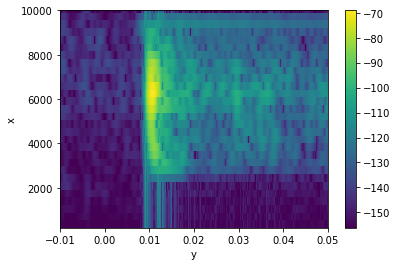

In [5]:
data.plot()

Nice! We can now go off and do things with this dataset.